## this gets the data into csv format

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [70]:
#this is commented out because it takes forever and I will just provide the filtered files. 
#however it is good to see how we did this

#open('filtered_data\q1_commit_messages_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q1_commit_messages.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q2_commit_dates_epoch_timestamp_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q2_commit_dates_epoch_timestamp.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q3_author_names_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q3_author_names.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q4_committer_names_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q4_committer_names.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q5_all_changed_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q5_all_changed_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q6_deleted_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q6_deleted_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q7_added_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q7_added_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q8_modified_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q8_modified_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q10_commit_count_by_project_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q10_commit_count_by_project.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q11_commits_all_langs_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q11_commits_all_langs.txt',encoding="utf8") if 'commit_log' in line)

## here we bring the filtered files in and merge the first set into one dataframe

In [3]:
messages = pd.read_csv('filtered_data/q1_commit_messages_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','message'])
timestamps = pd.read_csv('filtered_data/q2_commit_dates_epoch_timestamp_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','timestamp'])
authors = pd.read_csv('filtered_data/q3_author_names_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','author_name','commit_id'])
committers = pd.read_csv('filtered_data/q4_committer_names_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','committer_name'])

In [4]:
#merge all the message related files together
merge1 = pd.merge(messages,timestamps, on=['project_id','commit_id'])
merge2 = pd.merge(merge1, authors, on=['project_id','commit_id'])
merged_data = pd.merge(merge2,committers, on=['project_id','commit_id'])

In [5]:
#drop any rows that dont have a message because we dont need them
merged_data.dropna(subset=['message'], inplace=True)

In [6]:
#spit out all the messages to a file alone for processing by sentistrength
merged_data.message.to_csv('sentistrength_run/messages_only.csv', header=False, index=False)

## here, we manually run the sentistrength tool on the messages_only file, which produces the messages_only_results file which we can then merge with the main dataframe

In [7]:
#bring the strengths data in from the sentistrength results file
strengths = pd.read_csv('sentistrength_run/messages_only_results.txt', usecols=[1,2], sep='\t', dtype=str, names=['positive_strength','negative_strength'])

In [8]:
#merge the strengths with the main dataframe
merged_data.reset_index(drop=True, inplace=True)
commit_messages_final = pd.concat([merged_data,strengths],axis=1)

In [9]:
#convert the timestamp to date and add a day of week field
commit_messages_final["timestamp"] = commit_messages_final["timestamp"].astype(str)
commit_messages_final["timestamp"] = commit_messages_final["timestamp"].str[:10]
commit_messages_final['timestamp'] = pd.to_datetime(commit_messages_final['timestamp'],unit='s',errors='coerce')
commit_messages_final['day_of_week'] = commit_messages_final['timestamp'].dt.weekday_name
commit_messages_final['year'] = commit_messages_final['timestamp'].dt.year

In [10]:
#compute final sentiment value from sum of positive and negative
commit_messages_final['final_sentiment'] = pd.to_numeric(commit_messages_final['positive_strength']) + pd.to_numeric(commit_messages_final['negative_strength'])

## done with commit messages, moving on to changed files

In [11]:
#Bring in all the file related stuff
all_changes = pd.read_csv('filtered_data/q5_all_changed_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
deletes = pd.read_csv('filtered_data/q6_deleted_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
adds = pd.read_csv('filtered_data/q7_added_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
modifies = pd.read_csv('filtered_data/q8_modified_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])

In [12]:
#tag the deletes
merge_deletes = pd.merge(all_changes, deletes, on=['commit_id','filepath'], how='left', indicator='modif')
merge_deletes['modif'] = np.where(merge_deletes.modif == 'both', 'Delete', '')

In [13]:
#tag the adds
merge_adds = pd.merge(all_changes, adds, on=['commit_id','filepath'], how='left', indicator='modif')
merge_adds['modif'] = np.where(merge_adds.modif == 'both', 'Add', '')

In [14]:
#tag the modifies
merge_modifies = pd.merge(all_changes, modifies, on=['commit_id','filepath'], how='left', indicator='modif')
merge_modifies['modif'] = np.where(merge_modifies.modif == 'both', 'Modify', '')

In [15]:
#merge the deletes and adds tag frames together
temp_files_merge = pd.merge(merge_deletes, merge_adds, on=['commit_id','filepath'])

In [16]:
#squash down the columns in the delete/add frame so the tags are in the same column
temp_files_merge['modif'] = temp_files_merge['modif_x'].where(temp_files_merge['modif_x'] != '', temp_files_merge['modif_y'])
temp_files_merge = temp_files_merge.drop(['modif_x','modif_y'],axis=1)

In [17]:
#merge the delete/add frame and the modify frame together
temp_files_merge2 = pd.merge(temp_files_merge, merge_modifies, on=['commit_id','filepath'])

In [18]:
#squash down the columns in the final frame so the all tags are in the same column
temp_files_merge2['modification'] = temp_files_merge2['modif_x'].where(temp_files_merge2['modif_x'] != '', temp_files_merge2['modif_y'])
files_changed_final = temp_files_merge2.drop(['modif_x','modif_y'],axis=1)

##  here are the final pandas dataframes:

In [19]:
commit_messages_final.head()

,project_id,commit_id,message,timestamp,author_name,committer_name,positive_strength,negative_strength,day_of_week,year,final_sentiment
0,10000244,0515c7d89f97bf7f1e488ac39dcc8fe1ee79f605,photo in progress,2013-05-11 15:52:20,syhw,syhw,1,-1,Saturday,2013.0,0
1,10000244,07abeaf9bd85eb77f0774607161a7ccb3ed8dff3,stashing,2013-05-12 09:29:50,syhw,syhw,1,-1,Sunday,2013.0,0
2,10000244,11f46d585bfc263e11b0556566559e6513cca0e4,R,2013-05-12 12:10:17,syhw,syhw,1,-1,Sunday,2013.0,0
3,10000244,25ffeb626cd9146c483c6144b8208b5bd6cf26c4,"merged photo (working) with master, see TODOs...",2013-05-12 07:18:18,syhw,syhw,1,-1,Sunday,2013.0,0
4,10000244,33ac9b6d9da4234c93ae3d9e0d7b0f41edb99d8a,Request task,2013-05-12 10:01:57,syhw,syhw,1,-1,Sunday,2013.0,0


In [20]:
files_changed_final.head()

,commit_id,filepath,modification
0,000087431d696a16cd5cb5f96be0f64060e4b13d,src/org/rascalmpl/library/experiments/RascalT...,Modify
1,0003df884c8c06b9ee51fc403a3487a82fae7a7f,fileio/private/ft_fetch_header.m,Modify
2,0005eba750a10b9b3eda9f8cfb75bdc65c80a919,src/com/android/exchange/adapter/CalendarSync...,Modify
3,0005eba750a10b9b3eda9f8cfb75bdc65c80a919,src/com/android/exchange/utility/CalendarUtil...,Modify
4,00099da1b3b9d91574187e70182e5384debb3731,res/values-th/strings.xml,Modify


# Analysis

### RQ1

In [21]:
#count the number of commits for each sentiment level
commits_by_sentiment = commit_messages_final.groupby(['final_sentiment']).count().reset_index()
commits_by_sentiment = commits_by_sentiment[['final_sentiment','project_id']]
commits_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)

In [22]:
#bin the commits by positive, negative, and neutral sentiment
commits_by_sentiment['percent_of_total'] = commits_by_sentiment['count'].divide(len(commit_messages_final)).multiply(100)
commits_by_sentiment['bin'] = pd.cut(commits_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
commits_by_sentiment

,final_sentiment,count,percent_of_total,bin
0,-4,47,0.002086,negative
1,-3,1819,0.080736,negative
2,-2,31340,1.391018,negative
3,-1,262278,11.641144,negative
4,0,1821462,80.845139,neutral
5,1,125868,5.586620,positive
6,2,9911,0.439897,positive
7,3,295,0.013094,positive
8,4,6,0.000266,positive


In [23]:
#sum up the total percent of each bin
commits_by_sentiment_binned = commits_by_sentiment.groupby(['bin']).sum().reset_index()
commits_by_sentiment_binned = commits_by_sentiment_binned[['bin','count','percent_of_total']]
commits_by_sentiment_binned

,bin,count,percent_of_total
0,negative,295484,13.114984
1,neutral,1821462,80.845139
2,positive,136080,6.039877


In [24]:
commits_by_project = commit_messages_final.groupby(['project_id']).count().reset_index()

In [25]:
commits_by_project = commits_by_project[['project_id','commit_id']]
commits_by_project.rename(columns={'commit_id':'count'}, inplace=True)
commits_by_project.sort_values(['count'], inplace=True)

In [26]:
commits_by_project.to_csv('commits_by_project_sorted.csv', sep='\t', encoding='utf-8')

### manually obtained large, average and low groups by examining file

In [27]:
largelist = ['12496978','10613094','5153143','7785050','1968812']
avglist = ['2424377','5256179','365893','6719407','13010741']
lowlist = ['10453653','10530838','11416657','4067771','1571039']

In [28]:
large_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(largelist)]
avg_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(avglist)]
low_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(lowlist)]

In [29]:
#get bin percentages for large projects
large_by_sentiment = large_projects.groupby(['final_sentiment']).count().reset_index()
large_by_sentiment = large_by_sentiment[['final_sentiment','project_id']]
large_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
large_by_sentiment['percent_of_total'] = large_by_sentiment['count'].divide(len(large_projects)).multiply(100)
large_by_sentiment['bin'] = pd.cut(large_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
large_by_sentiment_binned = large_by_sentiment.groupby(['bin']).sum().reset_index()
large_by_sentiment_binned = large_by_sentiment_binned[['bin','count','percent_of_total']]
large_by_sentiment_binned

,bin,count,percent_of_total
0,negative,8568,15.728604
1,neutral,42061,77.212982
2,positive,3845,7.058413


In [30]:
#get bin percentages for average projects
avg_by_sentiment = avg_projects.groupby(['final_sentiment']).count().reset_index()
avg_by_sentiment = avg_by_sentiment[['final_sentiment','project_id']]
avg_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
avg_by_sentiment['percent_of_total'] = avg_by_sentiment['count'].divide(len(avg_projects)).multiply(100)
avg_by_sentiment['bin'] = pd.cut(avg_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
avg_by_sentiment_binned = avg_by_sentiment.groupby(['bin']).sum().reset_index()
avg_by_sentiment_binned = avg_by_sentiment_binned[['bin','count','percent_of_total']]
avg_by_sentiment_binned

,bin,count,percent_of_total
0,negative,3970,17.082616
1,neutral,17987,77.396730
2,positive,1283,5.520654


In [31]:
#get bin percentages for low projects
low_by_sentiment = low_projects.groupby(['final_sentiment']).count().reset_index()
low_by_sentiment = low_by_sentiment[['final_sentiment','project_id']]
low_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
low_by_sentiment['percent_of_total'] = low_by_sentiment['count'].divide(len(low_projects)).multiply(100)
low_by_sentiment['bin'] = pd.cut(low_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
low_by_sentiment_binned = low_by_sentiment.groupby(['bin']).sum().reset_index()
low_by_sentiment_binned = low_by_sentiment_binned[['bin','count','percent_of_total']]
low_by_sentiment_binned

,bin,count,percent_of_total
0,negative,606,9.724005
1,neutral,5306,85.141207
2,positive,320,5.134788


## RQ2

### Sort out day of week data for all commits

In [32]:
##create the bins per weekday
weekdays = commit_messages_final.groupby(['day_of_week',pd.cut(commit_messages_final.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays = weekdays.size().unstack()
weekdays.columns = [''.join(col).strip() for col in weekdays.columns.values]
weekdays.reset_index(inplace=True)

#get the totals again
weekdays['total'] = weekdays['negative'] + weekdays['neutral'] + weekdays['positive']
weekdays['negative_pct'] = weekdays['negative'].divide(weekdays['total']).multiply(100)
weekdays['neutral_pct'] = weekdays['neutral'].divide(weekdays['total']).multiply(100)
weekdays['positive_pct'] = weekdays['positive'].divide(weekdays['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays['day_of_week'].map(mapping)
weekdays = weekdays.iloc[key.argsort()].set_index('day_of_week')
weekdays.columns = [''.join(col).strip() for col in weekdays.columns.values]
weekdays.reset_index(inplace=True)
weekdays

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,44670,278781,20354,343805,12.992830,81.086953,5.920216
1,Tuesday,52833,315346,23561,391740,13.486751,80.498800,6.014448
2,Wednesday,52230,320689,24394,397313,13.145807,80.714449,6.139744
3,Thursday,50815,305385,22884,379084,13.404681,80.558662,6.036657
4,Friday,46786,284494,21198,352478,13.273453,80.712555,6.013992
5,Saturday,23342,151805,11362,186509,12.515214,81.392855,6.091931
6,Sunday,22738,155188,11491,189417,12.004202,81.929288,6.066509


### Sort out day of week data for large commits

In [33]:
##create the bins per weekday
weekdays_large = large_projects.groupby(['day_of_week',pd.cut(large_projects.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays_large = weekdays_large.size().unstack()
weekdays_large.columns = [''.join(col).strip() for col in weekdays_large.columns.values]
weekdays_large.reset_index(inplace=True)

#get the totals again
weekdays_large['total'] = weekdays_large['negative'] + weekdays_large['neutral'] + weekdays_large['positive']
weekdays_large['negative_pct'] = weekdays_large['negative'].divide(weekdays_large['total']).multiply(100)
weekdays_large['neutral_pct'] = weekdays_large['neutral'].divide(weekdays_large['total']).multiply(100)
weekdays_large['positive_pct'] = weekdays_large['positive'].divide(weekdays_large['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays_large['day_of_week'].map(mapping)
weekdays_large = weekdays_large.iloc[key.argsort()].set_index('day_of_week')
weekdays_large.columns = [''.join(col).strip() for col in weekdays_large.columns.values]
weekdays_large.reset_index(inplace=True)
weekdays_large

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,1255,6850,626,8731,14.374069,78.456076,7.169855
1,Tuesday,1684,7967,760,10411,16.175199,76.524830,7.299971
2,Wednesday,1853,8541,833,11227,16.504854,76.075532,7.419613
3,Thursday,1656,8052,744,10452,15.843858,77.037887,7.118255
4,Friday,1434,7371,598,9403,15.250452,78.389876,6.359672
5,Saturday,376,1779,161,2316,16.234888,76.813472,6.951641
6,Sunday,310,1501,123,1934,16.028956,77.611169,6.359876


### Sort out day of week data for average commits

In [34]:
##create the bins per weekday
weekdays_avg = avg_projects.groupby(['day_of_week',pd.cut(avg_projects.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays_avg = weekdays_avg.size().unstack()
weekdays_avg.columns = [''.join(col).strip() for col in weekdays_avg.columns.values]
weekdays_avg.reset_index(inplace=True)

#get the totals again
weekdays_avg['total'] = weekdays_avg['negative'] + weekdays_avg['neutral'] + weekdays_avg['positive']
weekdays_avg['negative_pct'] = weekdays_avg['negative'].divide(weekdays_avg['total']).multiply(100)
weekdays_avg['neutral_pct'] = weekdays_avg['neutral'].divide(weekdays_avg['total']).multiply(100)
weekdays_avg['positive_pct'] = weekdays_avg['positive'].divide(weekdays_avg['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays_avg['day_of_week'].map(mapping)
weekdays_avg = weekdays_avg.iloc[key.argsort()].set_index('day_of_week')
weekdays_avg.columns = [''.join(col).strip() for col in weekdays_avg.columns.values]
weekdays_avg.reset_index(inplace=True)
weekdays_avg

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,622,2813,215,3650,17.041096,77.068493,5.890411
1,Tuesday,757,3395,258,4410,17.165533,76.984127,5.850340
2,Wednesday,734,3294,229,4257,17.242189,77.378436,5.379375
3,Thursday,687,3333,218,4238,16.210477,78.645588,5.143936
4,Friday,714,3100,231,4045,17.651422,76.637824,5.710754
5,Saturday,229,1005,66,1300,17.615385,77.307692,5.076923
6,Sunday,227,1047,66,1340,16.940299,78.134328,4.925373


### Sort out day of week data for low commits

In [35]:
##create the bins per weekday
weekdays_low = low_projects.groupby(['day_of_week',pd.cut(low_projects.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])])
weekdays_low = weekdays_low.size().unstack()
weekdays_low.columns = [''.join(col).strip() for col in weekdays_low.columns.values]
weekdays_low.reset_index(inplace=True)

#get the totals again
weekdays_low['total'] = weekdays_low['negative'] + weekdays_low['neutral'] + weekdays_low['positive']
weekdays_low['negative_pct'] = weekdays_low['negative'].divide(weekdays_low['total']).multiply(100)
weekdays_low['neutral_pct'] = weekdays_low['neutral'].divide(weekdays_low['total']).multiply(100)
weekdays_low['positive_pct'] = weekdays_low['positive'].divide(weekdays_low['total']).multiply(100)

#a rube goldberg way to sort by day of week... FML
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = weekdays_low['day_of_week'].map(mapping)
weekdays_low = weekdays_low.iloc[key.argsort()].set_index('day_of_week')
weekdays_low.columns = [''.join(col).strip() for col in weekdays_low.columns.values]
weekdays_low.reset_index(inplace=True)
weekdays_low

,day_of_week,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Monday,115,1024,63,1202,9.567388,85.191348,5.241265
1,Tuesday,104,933,50,1087,9.567617,85.832567,4.599816
2,Wednesday,113,899,48,1060,10.660377,84.811321,4.528302
3,Thursday,102,938,58,1098,9.289617,85.428051,5.282332
4,Friday,95,848,48,991,9.586276,85.570131,4.843592
5,Saturday,33,315,27,375,8.800000,84.000000,7.200000
6,Sunday,44,349,26,419,10.501193,83.293556,6.205251


### graphing

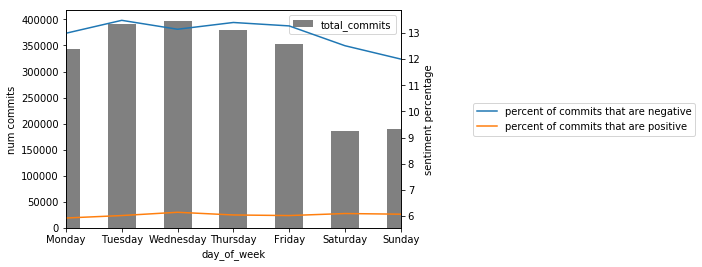

In [36]:
#graphing the data for all commits
ax = weekdays.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

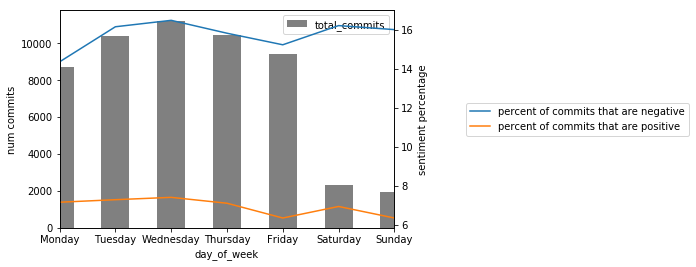

In [37]:
#graphing the data for large commits
ax = weekdays_large.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays_large['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays_large['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()
#enterprise programmers dont want to work on the weekend?

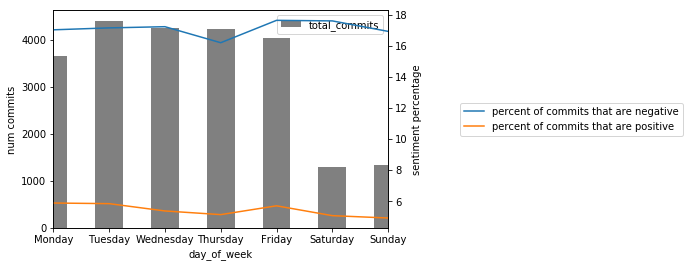

In [38]:
#graphing the data for average commits
ax = weekdays_avg.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays_avg['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays_avg['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

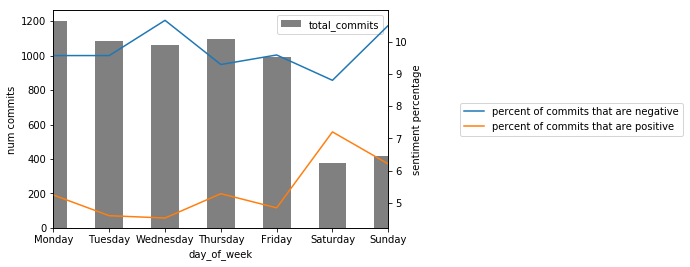

In [39]:
#graphing the data for low commits
ax = weekdays_low.plot.bar(x='day_of_week', y='total', color='grey', label='total_commits')
ax2 = weekdays_low['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = weekdays_low['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()
#perhaps hobby programmers who are happy to work on their small projects on the weekend

## RQ3
Is there a correlation between the number of changed files and developer sentiment? 

In [40]:
#count up all the changed files
files_changed_count = files_changed_final.groupby('commit_id').count().reset_index()
files_changed_count = files_changed_count[['commit_id', 'modification']]
files_changed_count.commit_id = files_changed_count.commit_id.astype(str)
files_changed_count.commit_id = files_changed_count.commit_id.str.strip()

In [41]:
commit_messages_rq3 = commit_messages_final
commit_messages_rq3.dropna(inplace=True)
commit_messages_rq3.commit_id = commit_messages_rq3.commit_id.astype(str)
commit_messages_rq3.commit_id = commit_messages_rq3.commit_id.str.strip()

##### Merge Dataframes:

In [42]:
commit_file_count = files_changed_count.merge(commit_messages_rq3,on='commit_id', how='left')
commit_file_count = commit_file_count[(commit_file_count.year >= 2008) & (commit_file_count.year <= 2015) ]

In [43]:
commit_file_count_large = commit_file_count.loc[commit_file_count['project_id'].isin(largelist)]
commit_file_count_avg = commit_file_count.loc[commit_file_count['project_id'].isin(avglist)]
commit_file_count_low = commit_file_count.loc[commit_file_count['project_id'].isin(lowlist)]

In [44]:
#do some really nasty rearanging of indexes
years_large = commit_file_count_large.groupby(['year',pd.cut(commit_file_count_large.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).sum()
years_large.columns = ['num_files_modified','garbage','garbage2']
years_large = years_large.unstack()
years_large.columns = [' '.join(col).strip() for col in years_large.columns.values]
years_large.reset_index(inplace=True)
years_large = years_large[['year','num_files_modified negative','num_files_modified neutral','num_files_modified positive']]
years_large.columns = ['year','negative_mod_count','neutral_mod_count','positive_mod_count']

temp=commit_file_count_large.groupby(['year']).mean()
temp.reset_index(inplace=True)
temp = temp[['year','modification']]
temp.columns = ['year','avg_files_modified']

years_large = years_large.merge(temp,on='year')
years_large

,year,negative_mod_count,neutral_mod_count,positive_mod_count,avg_files_modified
0,2008.0,2742,9755,139,24.488372
1,2009.0,14431,82193,5073,19.378239
2,2010.0,110958,290256,39892,53.603840
3,2011.0,73217,321998,19801,43.968217
4,2012.0,24762,223128,11344,25.066138
5,2013.0,24337,395590,20936,33.474791
6,2014.0,7367,349117,1275,60.360891
7,2015.0,271,1083,114,4.194286


In [45]:
years_avg = commit_file_count_avg.groupby(['year',pd.cut(commit_file_count_avg.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).sum()
years_avg.columns = ['num_files_modified','garbage','garbage2']
years_avg = years_avg.unstack()
years_avg.columns = [' '.join(col).strip() for col in years_avg.columns.values]
years_avg.reset_index(inplace=True)
years_avg = years_avg[['year','num_files_modified negative','num_files_modified neutral','num_files_modified positive']]
years_avg.columns = ['year','negative_mod_count','neutral_mod_count','positive_mod_count']

temp=commit_file_count_avg.groupby(['year']).mean()
temp.reset_index(inplace=True)
temp = temp[['year','modification']]
temp.columns = ['year','avg_files_modified']

years_avg = years_avg.merge(temp,on='year')
years_avg

,year,negative_mod_count,neutral_mod_count,positive_mod_count,avg_files_modified
0,2008.0,1996,13240,5862,9.831314
1,2009.0,10428,60416,2323,11.918391
2,2010.0,10236,39533,1766,17.218510
3,2011.0,15812,68231,1925,20.458829
4,2012.0,3328,48551,2535,16.867328
5,2013.0,1258,8167,106,15.080696
6,2014.0,53,1093,59,9.877049
7,2015.0,28,1078,7,17.123077


In [46]:
years_low = commit_file_count_low.groupby(['year',pd.cut(commit_file_count_low.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).sum()
years_low.columns = ['num_files_modified','garbage','garbage2']
years_low = years_low.unstack()
years_low.columns = [' '.join(col).strip() for col in years_low.columns.values]
years_low.reset_index(inplace=True)
years_low = years_low[['year','num_files_modified negative','num_files_modified neutral','num_files_modified positive']]
years_low.columns = ['year','negative_mod_count','neutral_mod_count','positive_mod_count']
years_low = years_low.fillna(0)

temp=commit_file_count_low.groupby(['year']).mean()
temp.reset_index(inplace=True)
temp = temp[['year','modification']]
temp.columns = ['year','avg_files_modified']

years_low = years_low.merge(temp,on='year')
years_low

,year,negative_mod_count,neutral_mod_count,positive_mod_count,avg_files_modified
0,2008.0,392.0,1377.0,58.0,3.155440
1,2009.0,149.0,979.0,41.0,2.205660
2,2010.0,41.0,387.0,27.0,1.691450
3,2011.0,23.0,3229.0,201.0,17.179104
4,2012.0,668.0,9819.0,645.0,8.319880
5,2013.0,669.0,21838.0,846.0,9.803946
6,2014.0,0.0,51.0,11.0,4.428571


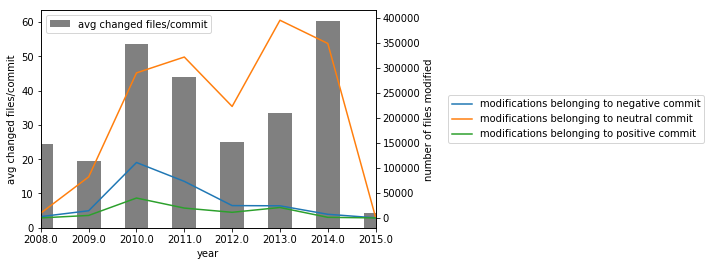

In [47]:
#graphing the data for large commits
ax = years_large.plot.bar(x='year', y='avg_files_modified', color='grey', label='avg changed files/commit')
ax2 = years_large['negative_mod_count'].plot(secondary_y=True, label='modifications belonging to negative commit')
ax2 = years_large['neutral_mod_count'].plot(secondary_y=True, label='modifications belonging to neutral commit')
ax3 = years_large['positive_mod_count'].plot(secondary_y=True, label='modifications belonging to positive commit')
ax.set_ylabel('avg changed files/commit')
ax2.set_ylabel('number of files modified')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

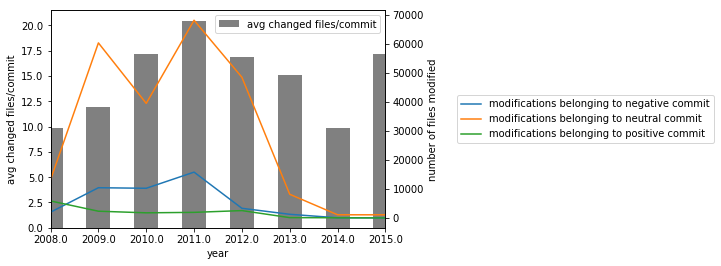

In [48]:
#graphing the data for average commits
ax = years_avg.plot.bar(x='year', y='avg_files_modified', color='grey', label='avg changed files/commit')
ax2 = years_avg['negative_mod_count'].plot(secondary_y=True, label='modifications belonging to negative commit')
ax2 = years_avg['neutral_mod_count'].plot(secondary_y=True, label='modifications belonging to neutral commit')
ax3 = years_avg['positive_mod_count'].plot(secondary_y=True, label='modifications belonging to positive commit')
ax.set_ylabel('avg changed files/commit')
ax2.set_ylabel('number of files modified')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

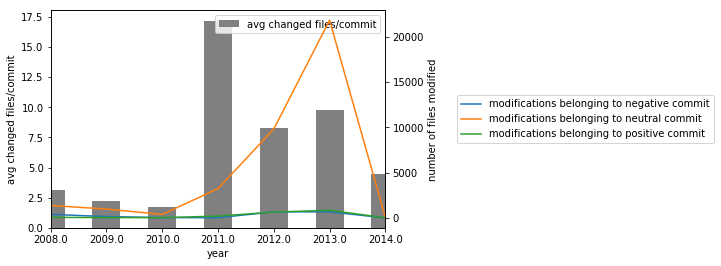

In [49]:
#graphing the data for low commits
ax = years_low.plot.bar(x='year', y='avg_files_modified', color='grey', label='avg changed files/commit')
ax2 = years_low['negative_mod_count'].plot(secondary_y=True, label='modifications belonging to negative commit')
ax2 = years_low['neutral_mod_count'].plot(secondary_y=True, label='modifications belonging to neutral commit')
ax3 = years_low['positive_mod_count'].plot(secondary_y=True, label='modifications belonging to positive commit')
ax.set_ylabel('avg changed files/commit')
ax2.set_ylabel('number of files modified')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

# RQ4

Is there a correlation between type of file modification and sentiment

In [50]:
#cound the number of each type of modification for each commit
files_changed_rq4 = files_changed_final.groupby(['modification','commit_id']).count().reset_index()
files_changed_rq4 = files_changed_rq4.pivot(index='commit_id', columns='modification', values='filepath')
files_changed_rq4.columns = [''.join(col).strip() for col in files_changed_rq4.columns.values]
files_changed_rq4.reset_index(inplace=True)
files_changed_rq4.fillna(0, inplace=True)

In [51]:
#get the totals again and get percentages
files_changed_rq4['total'] = files_changed_rq4['Add'] + files_changed_rq4['Delete'] + files_changed_rq4['Modify']
files_changed_rq4['add_pct'] = files_changed_rq4['Add'].divide(files_changed_rq4['total']).multiply(100)
files_changed_rq4['delete_pct'] = files_changed_rq4['Delete'].divide(files_changed_rq4['total']).multiply(100)
files_changed_rq4['modify_pct'] = files_changed_rq4['Modify'].divide(files_changed_rq4['total']).multiply(100)

In [52]:
#get commit messages and strip any nasty hidden characters
commit_messages_rq4 = commit_messages_final
commit_messages_rq4.dropna(inplace=True)
commit_messages_rq4.commit_id = commit_messages_rq4.commit_id.astype(str)
commit_messages_rq4.commit_id = commit_messages_rq4.commit_id.str.strip()

files_changed_rq4.commit_id = files_changed_rq4.commit_id.astype(str)
files_changed_rq4.commit_id = files_changed_rq4.commit_id.str.strip()

In [53]:
#break apart the three size groups
commit_mod_count = files_changed_rq4.merge(commit_messages_rq4,on='commit_id', how='left')
commit_mod_count_large = commit_mod_count.loc[commit_mod_count['project_id'].isin(largelist)]
commit_mod_count_avg = commit_mod_count.loc[commit_mod_count['project_id'].isin(avglist)]
commit_mod_count_low = commit_mod_count.loc[commit_mod_count['project_id'].isin(lowlist)]

In [54]:
#group by whichever type of modification is greater than 80% of the modifications in each commit
#throw away commits that arent strongly leaning toward one type, as in not greater than 80% adds, modifies, or deletes
commit_mod_count_large.loc[(commit_mod_count_large.add_pct >= 80), 'majority_mod'] = 'add'
commit_mod_count_large.loc[(commit_mod_count_large.delete_pct >= 80), 'majority_mod'] = 'delete' 
commit_mod_count_large.loc[(commit_mod_count_large.modify_pct >= 80), 'majority_mod'] = 'modify' 
commit_mod_count_large.dropna(inplace=True)
commit_mod_count_large = commit_mod_count_large.groupby(['majority_mod',pd.cut(commit_mod_count_large.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).count()
commit_mod_count_large = commit_mod_count_large.unstack()
commit_mod_count_large.columns = [' '.join(col).strip() for col in commit_mod_count_large.columns.values]
commit_mod_count_large.reset_index(inplace=True)
commit_mod_count_large = commit_mod_count_large[['majority_mod','commit_id negative','commit_id neutral','commit_id positive']]
commit_mod_count_large.columns = ['majority_mod','negative_commit_count','neutral_commit_count','positive_commit_count']

#get the totals again
commit_mod_count_large['total'] = commit_mod_count_large['negative_commit_count'] + commit_mod_count_large['neutral_commit_count'] + commit_mod_count_large['positive_commit_count']
commit_mod_count_large['negative_pct'] = commit_mod_count_large['negative_commit_count'].divide(commit_mod_count_large['total']).multiply(100)
commit_mod_count_large['neutral_pct'] = commit_mod_count_large['neutral_commit_count'].divide(commit_mod_count_large['total']).multiply(100)
commit_mod_count_large['positive_pct'] = commit_mod_count_large['positive_commit_count'].divide(commit_mod_count_large['total']).multiply(100)

commit_mod_count_large

,majority_mod,negative_commit_count,neutral_commit_count,positive_commit_count,total,negative_pct,neutral_pct,positive_pct
0,add,277,1480,104,1861,14.884471,79.527136,5.588393
1,delete,124,378,17,519,23.892100,72.832370,3.275530
2,modify,7583,37123,3361,48067,15.775896,77.231781,6.992323


In [55]:
#group by whichever type of modification is greater than 80% of the modifications in each commit
#throw away commits that arent strongly leaning toward one type, as in not greater than 80% adds, modifies, or deletes
commit_mod_count_avg.loc[(commit_mod_count_avg.add_pct >= 80), 'majority_mod'] = 'add'
commit_mod_count_avg.loc[(commit_mod_count_avg.delete_pct >= 80), 'majority_mod'] = 'delete' 
commit_mod_count_avg.loc[(commit_mod_count_avg.modify_pct >= 80), 'majority_mod'] = 'modify' 
commit_mod_count_avg.dropna(inplace=True)
commit_mod_count_avg = commit_mod_count_avg.groupby(['majority_mod',pd.cut(commit_mod_count_avg.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).count()
commit_mod_count_avg = commit_mod_count_avg.unstack()
commit_mod_count_avg.columns = [' '.join(col).strip() for col in commit_mod_count_avg.columns.values]
commit_mod_count_avg.reset_index(inplace=True)
commit_mod_count_avg = commit_mod_count_avg[['majority_mod','commit_id negative','commit_id neutral','commit_id positive']]
commit_mod_count_avg.columns = ['majority_mod','negative_commit_count','neutral_commit_count','positive_commit_count']

#get the totals again
commit_mod_count_avg['total'] = commit_mod_count_avg['negative_commit_count'] + commit_mod_count_avg['neutral_commit_count'] + commit_mod_count_avg['positive_commit_count']
commit_mod_count_avg['negative_pct'] = commit_mod_count_avg['negative_commit_count'].divide(commit_mod_count_avg['total']).multiply(100)
commit_mod_count_avg['neutral_pct'] = commit_mod_count_avg['neutral_commit_count'].divide(commit_mod_count_avg['total']).multiply(100)
commit_mod_count_avg['positive_pct'] = commit_mod_count_avg['positive_commit_count'].divide(commit_mod_count_avg['total']).multiply(100)

commit_mod_count_avg

,majority_mod,negative_commit_count,neutral_commit_count,positive_commit_count,total,negative_pct,neutral_pct,positive_pct
0,add,84,578,43,705,11.914894,81.985816,6.099291
1,delete,38,171,4,213,17.840376,80.281690,1.877934
2,modify,3475,15161,1050,19686,17.652139,77.014122,5.333740


In [56]:
#group by whichever type of modification is greater than 80% of the modifications in each commit
#throw away commits that arent strongly leaning toward one type, as in not greater than 80% adds, modifies, or deletes
commit_mod_count_low.loc[(commit_mod_count_low.add_pct >= 80), 'majority_mod'] = 'add'
commit_mod_count_low.loc[(commit_mod_count_low.delete_pct >= 80), 'majority_mod'] = 'delete' 
commit_mod_count_low.loc[(commit_mod_count_low.modify_pct >= 80), 'majority_mod'] = 'modify' 
commit_mod_count_low.dropna(inplace=True)
commit_mod_count_low = commit_mod_count_low.groupby(['majority_mod',pd.cut(commit_mod_count_low.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).count()
commit_mod_count_low = commit_mod_count_low.unstack()
commit_mod_count_low.columns = [' '.join(col).strip() for col in commit_mod_count_low.columns.values]
commit_mod_count_low.reset_index(inplace=True)
commit_mod_count_low = commit_mod_count_low[['majority_mod','commit_id negative','commit_id neutral','commit_id positive']]
commit_mod_count_low.columns = ['majority_mod','negative_commit_count','neutral_commit_count','positive_commit_count']
commit_mod_count_low.fillna(0, inplace=True)

#get the totals again
commit_mod_count_low['total'] = commit_mod_count_low['negative_commit_count'] + commit_mod_count_low['neutral_commit_count'] + commit_mod_count_low['positive_commit_count']
commit_mod_count_low['negative_pct'] = commit_mod_count_low['negative_commit_count'].divide(commit_mod_count_low['total']).multiply(100)
commit_mod_count_low['neutral_pct'] = commit_mod_count_low['neutral_commit_count'].divide(commit_mod_count_low['total']).multiply(100)
commit_mod_count_low['positive_pct'] = commit_mod_count_low['positive_commit_count'].divide(commit_mod_count_low['total']).multiply(100)

commit_mod_count_low

,majority_mod,negative_commit_count,neutral_commit_count,positive_commit_count,total,negative_pct,neutral_pct,positive_pct
0,add,10.0,217.0,8.0,235.0,4.255319,92.340426,3.404255
1,delete,8.0,37.0,0.0,45.0,17.777778,82.222222,0.000000
2,modify,544.0,4508.0,260.0,5312.0,10.240964,84.864458,4.894578


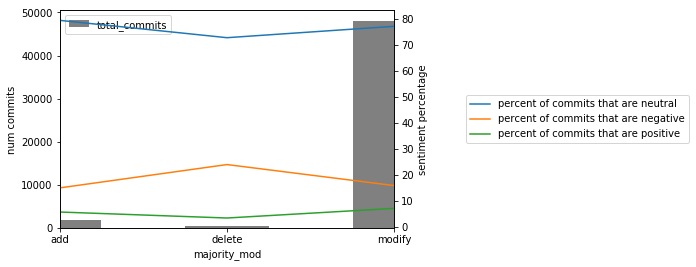

In [57]:
#graphing the data for large projects
ax = commit_mod_count_large.plot.bar(x='majority_mod', y='total', color='grey', label='total_commits')
ax1 = commit_mod_count_large['neutral_pct'].plot(secondary_y=True, label='percent of commits that are neutral')
ax2 = commit_mod_count_large['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = commit_mod_count_large['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

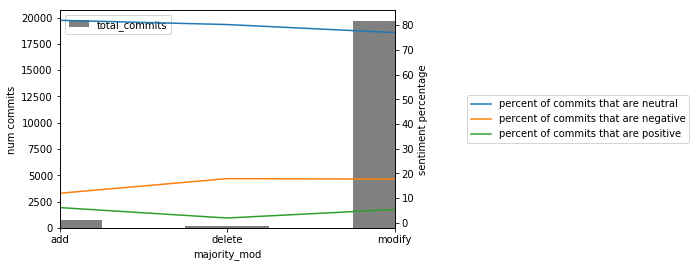

In [58]:
#graphing the data for average projects
ax = commit_mod_count_avg.plot.bar(x='majority_mod', y='total', color='grey', label='total_commits')
ax1 = commit_mod_count_avg['neutral_pct'].plot(secondary_y=True, label='percent of commits that are neutral')
ax2 = commit_mod_count_avg['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = commit_mod_count_avg['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

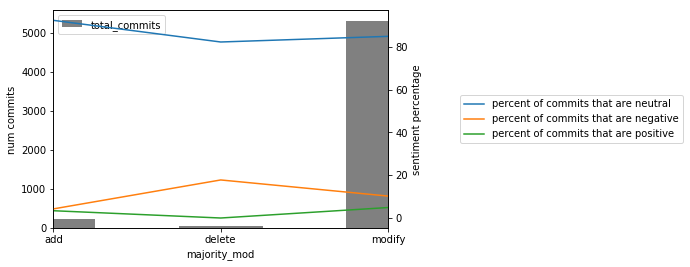

In [59]:
#graphing the data for low projects
ax = commit_mod_count_low.plot.bar(x='majority_mod', y='total', color='grey', label='total_commits')
ax1 = commit_mod_count_low['neutral_pct'].plot(secondary_y=True, label='percent of commits that are neutral')
ax2 = commit_mod_count_low['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = commit_mod_count_low['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

# RQ5

How does the project sentiment change over the life of the project? (beginning, middle, and end)

In [60]:
commit_messages_rq5 = commit_messages_final[(commit_messages_final.year >= 2008) & (commit_messages_final.year <= 2015) ]
project_dates = commit_messages_rq5.groupby('project_id')['timestamp'].agg(['max','min'])
project_dates['age_days'] = project_dates['max'].sub(project_dates['min'], axis=0)
project_dates['age_days'] = project_dates['age_days'] / np.timedelta64(1, 'D')
project_dates = project_dates[project_dates.age_days >= 30]

project_dates['age_days'] = np.around(project_dates['age_days'], decimals=-1)
project_dates['chunk_size_days'] = np.around(project_dates['age_days'] / 3, decimals=-1)
days_to_shift = project_dates['chunk_size_days'].apply(lambda x: pd.Timedelta(x, unit='D'))
project_dates['chunk1_end'] = project_dates['min'] + days_to_shift
project_dates['chunk2_end'] = project_dates['chunk1_end'] + days_to_shift
project_dates.reset_index(inplace=True)
project_dates.head()

,project_id,max,min,age_days,chunk_size_days,chunk1_end,chunk2_end
0,2019,2014-03-21 03:26:36,2008-01-09 17:41:21,2260.0,750.0,2010-01-28 17:41:21,2012-02-17 17:41:21
1,15623,2010-11-10 16:46:52,2008-01-26 15:07:24,1020.0,340.0,2008-12-31 15:07:24,2009-12-06 15:07:24
2,25193,2013-09-11 08:30:38,2008-01-02 08:14:46,2080.0,690.0,2009-11-22 08:14:46,2011-10-13 08:14:46
3,31107,2009-06-03 22:14:29,2008-05-08 01:40:15,390.0,130.0,2008-09-15 01:40:15,2009-01-23 01:40:15
4,33468,2009-02-01 14:58:58,2008-07-12 03:19:44,200.0,70.0,2008-09-20 03:19:44,2008-11-29 03:19:44


In [61]:
commit_messages_with_dates = commit_messages_rq5.merge(project_dates,on='project_id', how='left')
commit_messages_with_dates = pd.merge(commit_messages_rq5, project_dates, on=['project_id'], how='inner')

In [62]:
commit_messages_with_dates.loc[(commit_messages_with_dates['timestamp'] >= commit_messages_with_dates['min']) & (commit_messages_with_dates['timestamp'] < commit_messages_with_dates['chunk1_end']), 'time_section'] = 'beginning'
commit_messages_with_dates.loc[(commit_messages_with_dates['timestamp'] >= commit_messages_with_dates['chunk1_end']) & (commit_messages_with_dates['timestamp'] < commit_messages_with_dates['chunk2_end']), 'time_section'] = 'middle'
commit_messages_with_dates.loc[(commit_messages_with_dates['timestamp'] >= commit_messages_with_dates['chunk2_end']) & (commit_messages_with_dates['timestamp'] <= commit_messages_with_dates['max']), 'time_section'] = 'end'

In [63]:
time_sections = commit_messages_with_dates.groupby(['time_section',pd.cut(commit_messages_with_dates.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).count()
time_sections = time_sections.unstack()
time_sections.columns = [' '.join(col).strip() for col in time_sections.columns.values]
time_sections.reset_index(inplace=True)
time_sections = time_sections[['time_section','project_id negative','project_id neutral','project_id positive']]
time_sections.columns = ['time_section','negative_commit_count','neutral_commit_count','positive_commit_count']

sections = ['beginning','middle','end']
mapping = {section: i for i, section in enumerate(sections)}
key = time_sections['time_section'].map(mapping)
time_sections = time_sections.iloc[key.argsort()].set_index('time_section')
time_sections.columns = [''.join(col).strip() for col in time_sections.columns.values]
time_sections.reset_index(inplace=True)

time_sections['total'] = time_sections['negative_commit_count'] + time_sections['neutral_commit_count'] + commit_mod_count_avg['positive_commit_count']
time_sections['negative_pct'] = time_sections['negative_commit_count'].divide(time_sections['total']).multiply(100)
time_sections['neutral_pct'] = time_sections['neutral_commit_count'].divide(time_sections['total']).multiply(100)
time_sections['positive_pct'] = time_sections['positive_commit_count'].divide(time_sections['total']).multiply(100)

time_sections.head()

,time_section,negative_commit_count,neutral_commit_count,positive_commit_count,total,negative_pct,neutral_pct,positive_pct
0,beginning,96120,627840,46052,724003,13.276188,86.717873,6.360747
1,middle,86687,479786,37867,566477,15.302828,84.696466,6.684649
2,end,70606,425717,32105,497373,14.195785,85.593106,6.454914


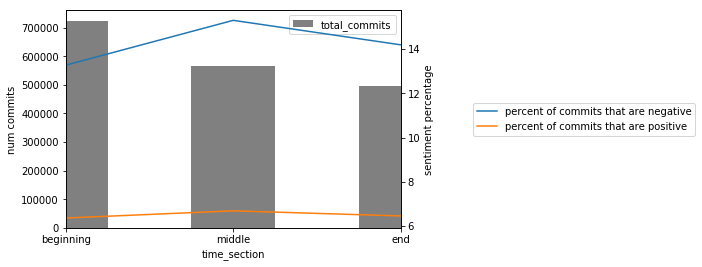

In [64]:
ax = time_sections.plot.bar(x='time_section', y='total', color='grey', label='total_commits')
ax2 = time_sections['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = time_sections['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

# RQ6

How does sentiment differ accross different languages

According to boa, the top 5 project languages are:
counts = JavaScript, 147668.0
counts = Ruby, 89104.0
counts = Shell, 70162.0
counts = Python, 62274.0
counts = Java, 55831.0

In [86]:
all_lang_messages = pd.read_csv('filtered_data/q11_commits_all_langs_filtered.txt', usecols=[0,1,2,3], sep='\|\|\|', names=['project_id','commit_id','language','message'])

#drop any rows that dont have a message because we dont need them
all_lang_messages.dropna(subset=['message'], inplace=True)

#spit out all the messages to a file alone for processing by sentistrength
all_lang_messages.message.to_csv('sentistrength_run/messages_only_all_langs.csv', header=False, index=False)

In [98]:
strengths_all_langs = pd.read_csv('sentistrength_run/messages_only_all_langs_results.txt', usecols=[1,2], sep='\t', dtype=str, names=['positive_strength','negative_strength'])

In [106]:
all_lang_messages.reset_index(drop=True, inplace=True)
strengths_all_langs.reset_index(drop=True, inplace=True)
commit_messages_rq6 = pd.concat([all_lang_messages,strengths_all_langs],axis=1)
#commit_messages_rq6.dropna(inplace=True)

In [116]:
commit_messages_rq6['final_sentiment'] = pd.to_numeric(commit_messages_rq6['positive_strength']) + pd.to_numeric(commit_messages_rq6['negative_strength'])
langs = commit_messages_rq6.groupby(['language',pd.cut(commit_messages_rq6.final_sentiment, bins = [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])]).count()

In [117]:
langs_unstacked = langs.unstack()
langs_unstacked.columns = [' '.join(col).strip() for col in langs_unstacked.columns.values]
langs_unstacked.reset_index(inplace=True)

In [118]:
langs_unstacked = langs_unstacked[['language','commit_id negative','commit_id neutral','commit_id positive']]
langs_unstacked.columns = ['language','negative_commit_count','neutral_commit_count','positive_commit_count']

#get the totals again
langs_unstacked['total'] = langs_unstacked['negative_commit_count'] + langs_unstacked['neutral_commit_count'] + langs_unstacked['positive_commit_count']
langs_unstacked['negative_pct'] = langs_unstacked['negative_commit_count'].divide(langs_unstacked['total']).multiply(100)
langs_unstacked['neutral_pct'] = langs_unstacked['neutral_commit_count'].divide(langs_unstacked['total']).multiply(100)
langs_unstacked['positive_pct'] = langs_unstacked['positive_commit_count'].divide(langs_unstacked['total']).multiply(100)

langs_unstacked

,language,negative_commit_count,neutral_commit_count,positive_commit_count,total,negative_pct,neutral_pct,positive_pct
0,Java,127726,903646,60368,1091740,11.699306,82.771173,5.529522
1,JavaScript,83376,520195,38811,642382,12.979193,80.979075,6.041732
2,Python,138898,616676,45806,801380,17.332352,76.951758,5.715890
3,Ruby,57350,338385,26528,422263,13.581583,80.136076,6.282341
4,Shell,393626,2132551,184522,2710699,14.521199,78.671627,6.807174


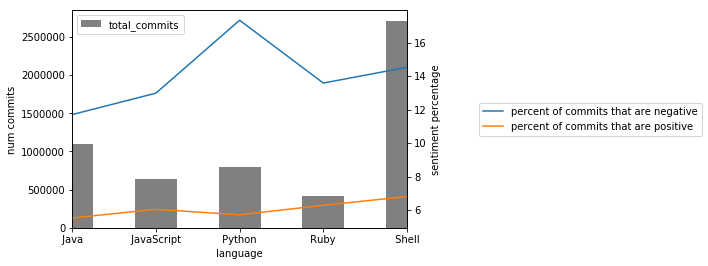

In [119]:
ax = langs_unstacked.plot.bar(x='language', y='total', color='grey', label='total_commits')
ax2 = langs_unstacked['negative_pct'].plot(secondary_y=True, label='percent of commits that are negative')
ax3 = langs_unstacked['positive_pct'].plot(secondary_y=True, label='percent of commits that are positive')
ax.set_ylabel('num commits')
ax2.set_ylabel('sentiment percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()